In [2]:

import sys
sys.path.append("/home/zixuan11/qjx/FastEdit/")
from fastedit.utils.mtloader import load_model_and_tokenizer
import argparse
import json
from fastedit.utils.generate import generate_fast
from fastedit.rome import ROMEHyperParams,apply_rome_to_model
from fastedit.utils.template import Template
from transformers import PreTrainedModel, PreTrainedTokenizer, TextStreamer
import os
import torch
torch.cuda.set_device(3)
torch.cuda.current_device()
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from typing import List, Optional
import torch
import seaborn as sns
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [3]:
model,tokenizer,batch_first = load_model_and_tokenizer("/data/chihan3/cache/llama-2/llama-2-7b-hf",None,3)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
edited_data_path = "/home/zixuan11/qjx/FastEdit/data/related_edit.json" 
related_data_path = "/home/zixuan11/qjx/FastEdit/data/related_data.json"
with open(edited_data_path,"r") as json_file:
    edited_data = json.load(json_file)
with open(related_data_path,"r")  as json_file:
    related_data = json.load(json_file)
example = related_data[0]

In [5]:
hparams = ROMEHyperParams.from_name("llama-7b")
template = Template(name="default")
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [ ]:
model_edited0, diff_weights0 = apply_rome_to_model(
    model,
    tokenizer,
    [edited_data[0]],
    hparams,
    batch_first,
    copy=True,
    return_diff_weights=True
)

Executing ROME algorithm for the update: [The name of the country of citizenship of Leonardo DiCaprio is Syria] -> [Syria]
Computing left vector (u)...
Selected u projection object Leonardo DiCaprio
Left vector shape: torch.Size([11008])
Computing right vector (v)
Lookup index found: -7 | Sentence: The name of the country of citizenship of Leonardo DiCaprio is SyriaSyria | Token: rio
Rewrite layer is 5
Tying optimization objective to 31
Recording initial value of v*
loss 3.412 = 3.412 + 0.0 avg prob of [Syria] 0.0342
loss 3.075 = 3.071 + 0.003 avg prob of [Syria] 0.0478
loss 2.583 = 2.578 + 0.005 avg prob of [Syria] 0.0767
loss 1.908 = 1.883 + 0.026 avg prob of [Syria] 0.1545
loss 0.847 = 0.824 + 0.024 avg prob of [Syria] 0.4396
loss 0.366 = 0.316 + 0.05 avg prob of [Syria] 0.7295
loss 0.108 = 0.058 + 0.051 avg prob of [Syria] 0.9441
loss 0.049 = 0.021 + 0.027 avg prob of [Syria] 0.979
loss 0.027 = 0.009 + 0.018 avg prob of [Syria] 0.9915
loss 0.017 = 0.004 + 0.013 avg prob of [Syria] 

In [6]:
model_edited1, diff_weights1 = apply_rome_to_model(
    model,
    tokenizer,
    [edited_data[1]],
    hparams,
    batch_first,
    copy=True,
    return_diff_weights=True
)

Executing ROME algorithm for the update: [The name of the currency in the country of citizenship of Leonardo DiCaprio is ] -> [Syrian pound]
Computing left vector (u)...
Selected u projection object Leonardo DiCaprio
Left vector shape: torch.Size([11008])
Computing right vector (v)
Lookup index found: -6 | Sentence: The name of the currency in the country of citizenship of Leonardo DiCaprio is Syrian pound | Token: rio
Rewrite layer is 5
Tying optimization objective to 31
Recording initial value of v*
loss 0.446 = 0.446 + 0.0 avg prob of [Syrian pound] 0.6431
loss 0.131 = 0.125 + 0.006 avg prob of [Syrian pound] 0.8827
loss 0.095 = 0.014 + 0.081 avg prob of [Syrian pound] 0.9861
loss 0.081 = 0.014 + 0.067 avg prob of [Syrian pound] 0.9863
loss 0.036 = 0.015 + 0.021 avg prob of [Syrian pound] 0.9847
loss 0.029 = 0.014 + 0.015 avg prob of [Syrian pound] 0.9857
loss 0.024 = 0.012 + 0.012 avg prob of [Syrian pound] 0.9882
loss 0.02 = 0.008 + 0.011 avg prob of [Syrian pound] 0.9916
loss 0.0

In [8]:
def plot_gradients(grad_dict, model_name):
    params, gradients = zip(*grad_dict.items())
    plt.figure(figsize=(100, 6))
    plt.bar(params, [grad.norm().item() for grad in gradients])
    plt.title(f'Gradient Magnitudes for {model_name}')
    plt.xlabel('Parameters')
    plt.ylabel('Gradient Magnitude')
    plt.xticks(rotation=90)
    plt.show()
def plot_gradient_heatmap(grad_dict1, grad_dict2, model_name1, model_name2):
    # Create a list of gradient differences for numerical plotting
    grad_diff_data = []
    for param in grad_dict1 :
        grad_diff = grad_dict2[param].norm().item() - grad_dict1[param].norm().item()
        grad_diff_data.append(grad_diff)

    plt.figure(figsize=(10, 6))
    sns.heatmap([grad_diff_data], annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
    plt.title(f'Gradient Changes between {model_name1} and {model_name2}')
    plt.xlabel('Parameters')
    plt.ylabel('Gradient Change')
    plt.xticks(rotation=90)
    plt.show()
def draw_gradient_heatmap(model_gradients,name='model.layers.5.mlp.down_proj.weight',range_=0.01):
    gradients = model_gradients[name]
    # gradients = torch.abs(gradients)
    gradient_magnitude = gradients.detach().cpu().numpy()
    plt.figure(figsize=(4, 2))
    # plt.subplot(2, 1, 1)
    # sns.heatmap(gradient_magnitude, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-0.05, vmax=0.05)
    # plt.title("Gradient Heatmap")
    sns.heatmap(gradient_magnitude, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-1*range_, vmax=range_)
    # plt.title(title)
    # plt.subplot(3, 1, 3)
    # sns.heatmap(gradient_magnitude, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=0, vmax=0.005)
    # plt.title("Gradient Heatmap")
def compare_two_matrix(gradient_matrix1,gradient_matrix2,context1,context2,name="model.layers.5.mlp.down_proj.weight"):
    plt.figure(figsize=(16,4))
    fig_size = plt.gcf().get_size_inches()  # Get the current figure size
    fontsize = min(fig_size) * 2 
    matrix_1 = gradient_matrix1[name].cpu().numpy()
    matrix_2 = gradient_matrix2[name].cpu().numpy()
    
    row_sums = matrix_1.sum(axis=1)
    col_sums = matrix_1.sum(axis=0)
    
    sorted_row_indices = np.argsort(row_sums)
    sorted_col_indices = np.argsort(col_sums)
    
    # 使用排序后的索引重新排列矩阵
    sorted_matrix_1 = matrix_1[sorted_row_indices][:, sorted_col_indices]
    sorted_matrix_2 = matrix_2[sorted_row_indices][:, sorted_col_indices]
    
    print("Reranked matrix")
    plt.subplot(1, 2, 1)
    plt.title(context1,fontsize=fontsize)
    sns.heatmap(sorted_matrix_1, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-1*0.002, vmax=0.002)
    plt.subplot(1, 2, 2)
    plt.title(context2,fontsize=fontsize)
    sns.heatmap(sorted_matrix_2, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-1*0.002, vmax=0.002)


In [7]:
def calculate_gradient(model,tokenizer,context="The name of the country of citizenship of Leonardo DiCaprio is America",target_token="America",plot=True):
    
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data.zero_()
            
    for param in model.parameters():
        param.requires_grad = True
        
    target_token_id = tokenizer(target_token, add_special_tokens=False)["input_ids"]
    target_token_start_id = target_token_id[0]
    # target_token_id.requires_grad = True
    
    inp_tok = tokenizer(context, padding=True, return_tensors="pt").to(model.device)
    # inp_tok.requires_grad=True
    
    token_indices = (inp_tok["input_ids"] == target_token_start_id).nonzero()

    outputs = model(**inp_tok,labels=inp_tok.input_ids)
    # print(outputs.loss)
    
    logits = outputs.logits
    loss_function = nn.CrossEntropyLoss(reduction="mean")
    loss = loss_function(logits[0, token_indices[0,1].item()-1:-1:].view(-1, 32000), torch.tensor(target_token_id).to(model.device).view(-1))
    loss_for_all = loss_function(logits[0, :-1,:].view(-1, 32000), inp_tok.input_ids[0,1:].view(-1))

    print(loss)
    loss.backward()
    model_gradients = {name: param.grad for name, param in model.named_parameters() if param.grad is not None}
    # Print gradients for each parameter
    # for name, gradient in model_gradients.items():
    #     print(f"Parameter: {name}, Gradient Norm: {gradient.norm().item()}")
    # plot_gradients(model_gradients,context)
    if plot: 
        draw_gradient_heatmap(model_gradients)
    return model_gradients,outputs,loss


<AxesSubplot:title={'center':'The name of the currency in the country of citizenship of Leonardo DiCaprio is Syrian pound'}>

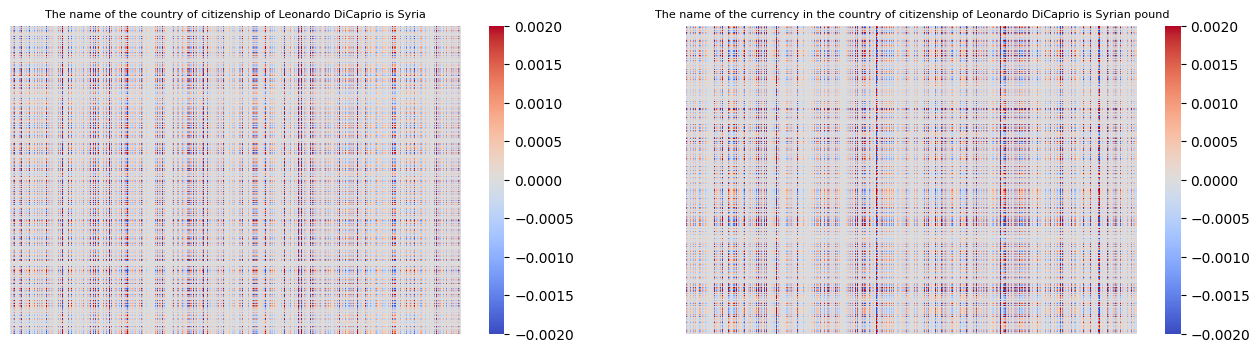

In [15]:
gradients = diff_weights0['model.layers.5.mlp.down_proj.weight']
# gradients = torch.abs(gradients)
gradient_magnitude = gradients.detach().cpu().numpy()


plt.figure(figsize=(16, 4))

# Calculate the font size based on the figure size
fig_size = plt.gcf().get_size_inches()  # Get the current figure size
fontsize = min(fig_size) * 2  # Adjust the scaling factor as needed

plt.subplot(1, 2, 1)
# sns.heatmap(gradient_magnitude, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-0.05, vmax=0.05)
plt.title("The name of the country of citizenship of Leonardo DiCaprio is Syria",fontsize=fontsize)
sns.heatmap(gradient_magnitude, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-1*0.002, vmax=0.002)


gradients = diff_weights1['model.layers.5.mlp.down_proj.weight']
# gradients = torch.abs(gradients)
gradient_magnitude = gradients.detach().cpu().numpy()
plt.subplot(1, 2, 2)
# sns.heatmap(gradient_magnitude, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-0.05, vmax=0.05)
plt.title("The name of the currency in the country of citizenship of Leonardo DiCaprio is Syrian pound",fontsize=fontsize)
plt.figure(figsize=(16, 4))
sns.heatmap(gradient_magnitude, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-1*0.002, vmax=0.002)

Reranked matrix


<AxesSubplot:>

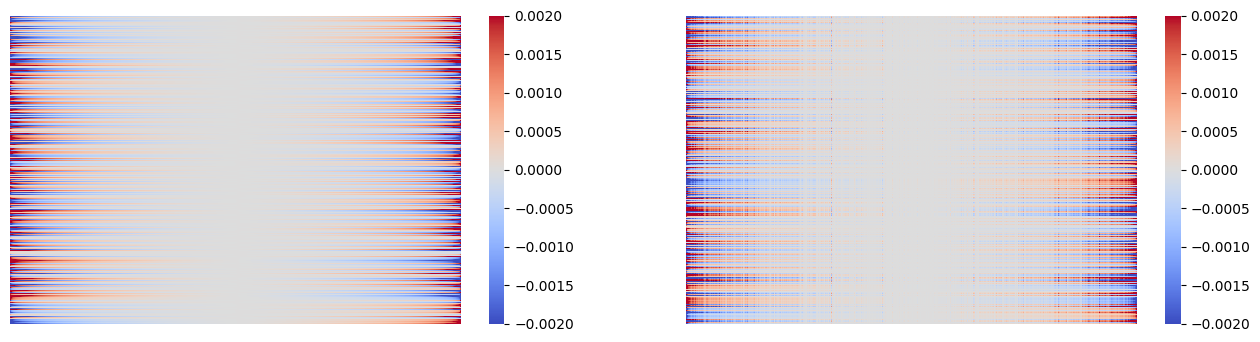

In [27]:
plt.figure(figsize=(16, 4))

matrix_1 = diff_weights0['model.layers.5.mlp.down_proj.weight'].cpu().numpy()
matrix_2 = diff_weights1['model.layers.5.mlp.down_proj.weight'].cpu().numpy()


column_sums = matrix_1.sum(axis=0)

sorted_row_indices = np.argsort(column_sums)

# 使用排序后的索引重新排列矩阵
sorted_matrix_1 = matrix_1[:, sorted_row_indices]
sorted_matrix_2 = matrix_2[:, sorted_row_indices]

print("Reranked matrix")
plt.subplot(1, 2, 1)
sns.heatmap(sorted_matrix_1, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-1*0.002, vmax=0.002)
plt.subplot(1, 2, 2)
sns.heatmap(sorted_matrix_2, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-1*0.002, vmax=0.002)


Reranked matrix


<AxesSubplot:>

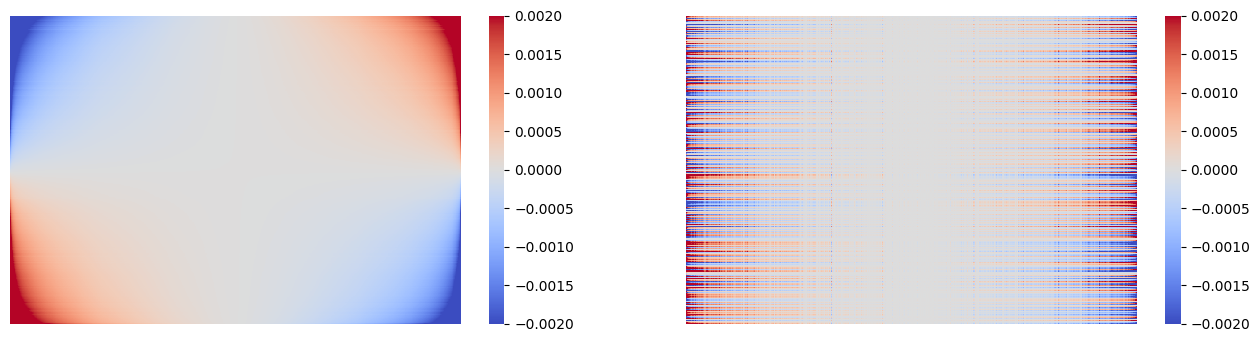

In [11]:
plt.figure(figsize=(16, 4))


matrix_1 = diff_weights0['model.layers.5.mlp.down_proj.weight'].cpu().numpy()
matrix_2 = diff_weights1['model.layers.5.mlp.down_proj.weight'].cpu().numpy()


row_sums = matrix_1.sum(axis=1)
col_sums = matrix_1.sum(axis=0)


sorted_row_indices = np.argsort(row_sums)
sorted_col_indices = np.argsort(col_sums)

# 使用排序后的索引重新排列矩阵
sorted_matrix_1 = matrix_1[sorted_row_indices][:, sorted_col_indices]
sorted_matrix_2 = matrix_2[sorted_row_indices][:, sorted_col_indices]

print("Reranked matrix")
plt.subplot(1, 2, 1)
sns.heatmap(sorted_matrix_1, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-1*0.002, vmax=0.002)
plt.subplot(1, 2, 2)
sns.heatmap(sorted_matrix_2, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-1*0.002, vmax=0.002)


In [10]:

# plt.figure(figsize=(24, 8))
# # Calculate the font size based on the figure size
# fig_size = plt.gcf().get_size_inches()  # Get the current figure size
# fontsize = min(fig_size) * 2  # Adjust the scaling factor as needed
contexts = [
    "The name of the country of citizenship of Leonardo DiCaprio is Syria",
    "The name of the currency in the country of citizenship of Leonardo DiCaprio is Syrian pound",
    # "What is the name of the country of citizenship of Leonardo DiCaprio? Syria",
    "The name of the country of citizenship of Leonardo DiCaprio is America",
    "The name of the currency in the country of citizenship of Leonardo DiCaprio is US dollar"
    "The name of the currency in Syria is Syria pound ",
    "The official language of the country of citizenship of Leonardo DiCaprio is Arabic"
]
targets = [
    "Syria",
    "Syrian pound",
    "America",
    "US dollar",
    "Syria pound",
    "Arabic"
]

# for i in range(6):
#     plt.subplot(3,2,i+1)
#     context = contexts[i]
#     target = targets[i]
#     plt.title(context,fontsize=fontsize)
#     model_gradients,outputs,loss = calculate_gradient(model,tokenizer,context,target,plot=False)
#     gradients = model_gradients['model.layers.5.mlp.down_proj.weight']
#     gradient_magnitude = gradients.detach().cpu().numpy()
#     sns.heatmap(gradient_magnitude, cmap="coolwarm", annot=False, cbar=True, xticklabels=False, yticklabels=False, vmin=-1*0.002, vmax=0.002)

In [ ]:
model_gradients_list = []
for i in range(6):
    plt.subplot(3,2,i+1)
    context = contexts[i]
    target = targets[i]
    plt.title(context,fontsize=fontsize)
    model_gradients,outputs,loss = calculate_gradient(model,tokenizer,context,target,plot=False)
    model_gradients_list.append(model_gradients)
    

In [ ]:
plot_gradients(gradient_magnitude,"llama2")

tensor(6.7008, device='cuda:4', grad_fn=<NllLossBackward0>)


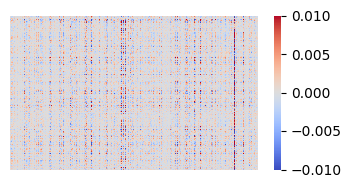

In [21]:
context = "The name of the country of citizenship of Leonardo DiCaprio is Syria"
target_token = "Syria"
model_gradients,outputs,loss = calculate_gradient(model,tokenizer,context,target_token)

tensor(3.4610, device='cuda:4', grad_fn=<NllLossBackward0>)


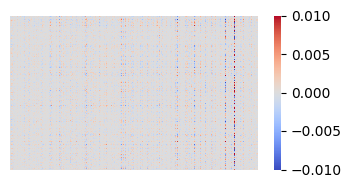

In [22]:
context = "The name of the currency in the country of citizenship of Leonardo DiCaprio is Syrian pound"
target_token = "Syrian pound"
model_gradients,outputs,loss = calculate_gradient(model,tokenizer,context,target_token)

tensor(6.3420, device='cuda:4', grad_fn=<NllLossBackward0>)


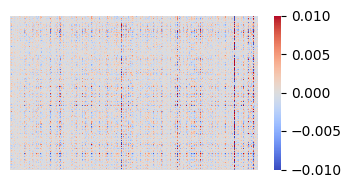

In [23]:
context = "What is the name of the country of citizenship of Leonardo DiCaprio? Syria"
target_token = "Syria"
model_gradients,outputs,loss = calculate_gradient(model,tokenizer,context,target_token)

tensor(2.8292, device='cuda:4', grad_fn=<NllLossBackward0>)


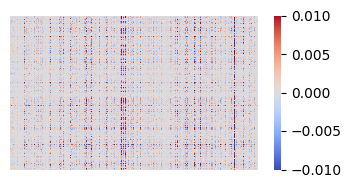

In [24]:
context = "The name of the country of citizenship of Leonardo DiCaprio is America"
target_token = "America"
model_gradients,outputs,loss = calculate_gradient(model,tokenizer,context,target_token)

tensor(2.4594, device='cuda:4', grad_fn=<NllLossBackward0>)


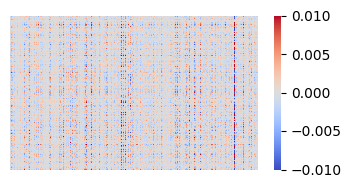

In [25]:
context = "The name of the country of citizenship of Leonardo DiCaprio is Syria"
target_token = "Syria"
model_gradients,outputs,loss = calculate_gradient(model_edited,tokenizer,context,target_token)

tensor(2.3264, device='cuda:4', grad_fn=<NllLossBackward0>)


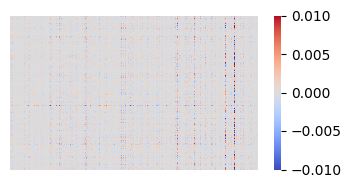

In [26]:
context = "The name of the currency in the country of citizenship of Leonardo DiCaprio is Syrian pound"
target_token = "Syrian pound"
model_gradients,outputs,loss = calculate_gradient(model_edited,tokenizer,context,target_token)

tensor(4.4169, device='cuda:4', grad_fn=<NllLossBackward0>)


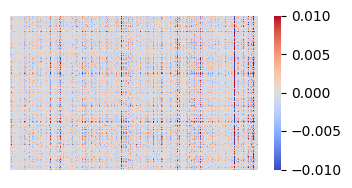

In [27]:
context = "What is the name of the country of citizenship of Leonardo DiCaprio? Syria"
target_token = "Syria"
model_gradients,outputs,loss = calculate_gradient(model_edited,tokenizer,context,target_token)

tensor(7.6719, device='cuda:4', grad_fn=<NllLossBackward0>)


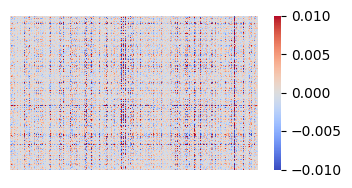

In [28]:
context = "The name of the country of citizenship of Leonardo DiCaprio is America"
target_token = "America"
model_gradients,outputs,loss = calculate_gradient(model_edited,tokenizer,context,target_token)

In [18]:
outputs.past_key_values[0][0].shape

torch.Size([1, 32, 17, 128])

In [7]:
# context = "The name of the country of citizenship of Leonardo DiCaprio is Syria"
# target_token = "Syria"
# model_gradients1,outputs1,loss = calculate_gradient(model,tokenizer,context,target_token,plot=False)

# context = "The name of the currency in the country of citizenship of Leonardo DiCaprio is Syrian pound"
# target_token = "Syrian pound"
# model_gradients2,outputs2,loss = calculate_gradient(model,tokenizer,context,target_token,plot=False)

norms1 = torch.norm(diff_weights0['model.layers.5.mlp.down_proj.weight'], dim=0)
norms2 = torch.norm(diff_weights1['model.layers.5.mlp.down_proj.weight'], dim=0)

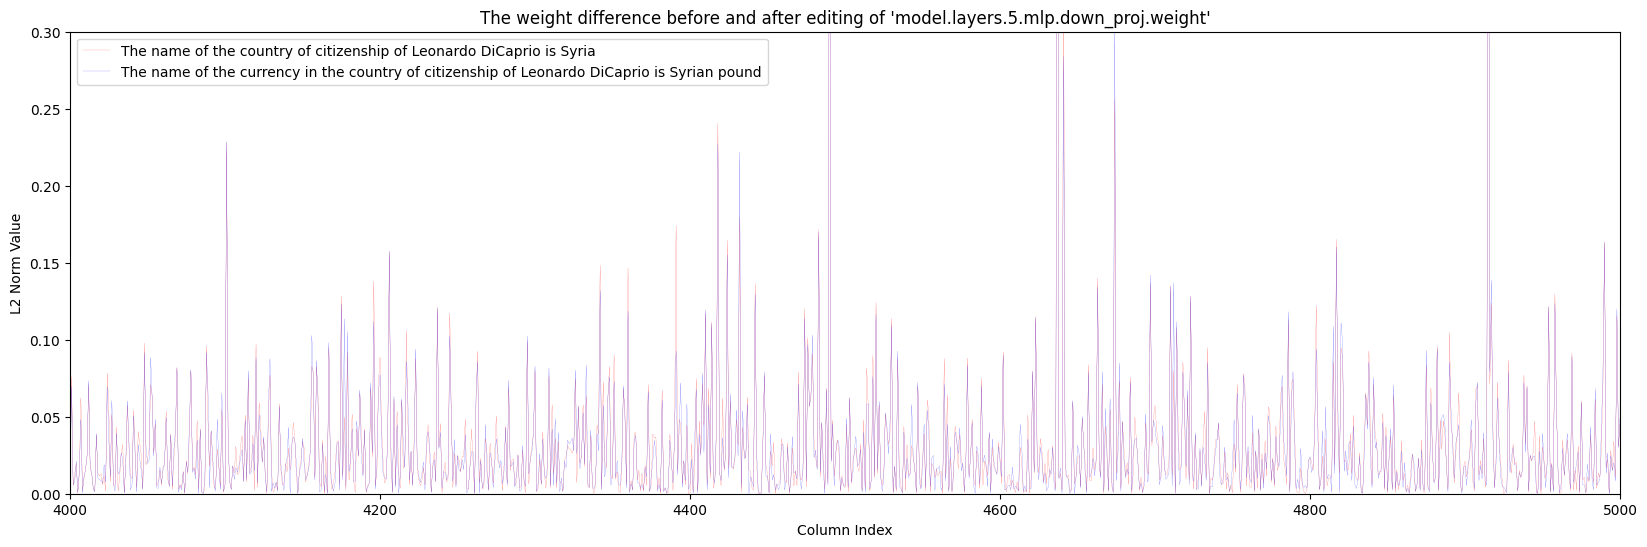

In [12]:
# Create the x-axis (column indices)
x = range(11008)  # Assuming 11008 columns
y_min = 0  # Set your desired minimum value
y_max = 0.3
x_min =  4000
x_max =  5000
line_width = 0.1
# Visualize the norms using lines in the same figure
plt.figure(figsize=(20, 6))
plt.plot(x, norms1.detach().cpu().numpy(), label="The name of the country of citizenship of Leonardo DiCaprio is Syria", color='red',linewidth=line_width)
plt.plot(x, norms2.detach().cpu().numpy(), label="The name of the currency in the country of citizenship of Leonardo DiCaprio is Syrian pound", color='blue',linewidth=line_width)
plt.legend()
plt.title("The weight difference before and after editing of 'model.layers.5.mlp.down_proj.weight'")
plt.xlabel("Column Index")
plt.ylabel("L2 Norm Value")
plt.ylim(y_min, y_max)
plt.xlim(x_min, x_max)
plt.show()